In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler   

import seaborn as sns
sns.set_style("dark")
colours_lst = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# Choose files
feature_file_dir = 'features'
feature_file_dir = 'features_word_pos'

relevant_pos_file = 'dataset/relevant_pos.txt'
relevant_pos_file = 'dataset/relevant_word_pos.txt'

# Load the feature files
feature_files = os.listdir(feature_file_dir)
features=[]
for file in feature_files:
    with open(f'{feature_file_dir}/{file}', 'rb') as f:
        features.append(pickle.load(f))
        
total_layers = len(features)
        
# Load tags list
with open(relevant_pos_file, 'r') as f:
    tags = f.read().splitlines()

### Stack Layers

In [2]:
# Combine all features from all layers into one array
X = np.hstack([np.hstack(layer) for layer in features])

# Create a list of tags: one for each tag * instances of that tag
t = []
for i in range(len(features[0])):
    t.extend([tags[i]]*features[0][i].shape[1])
 
# Create a list of layers: one for each tag * instances of that tag, repeated for each layer
layer = []
for i in range(total_layers):
    layer.extend([i+1]*len(t))

# Duplicate the tags for each layer
t *= total_layers

### Choose POS Tags & Layers, Fit PCA, Plot Layers

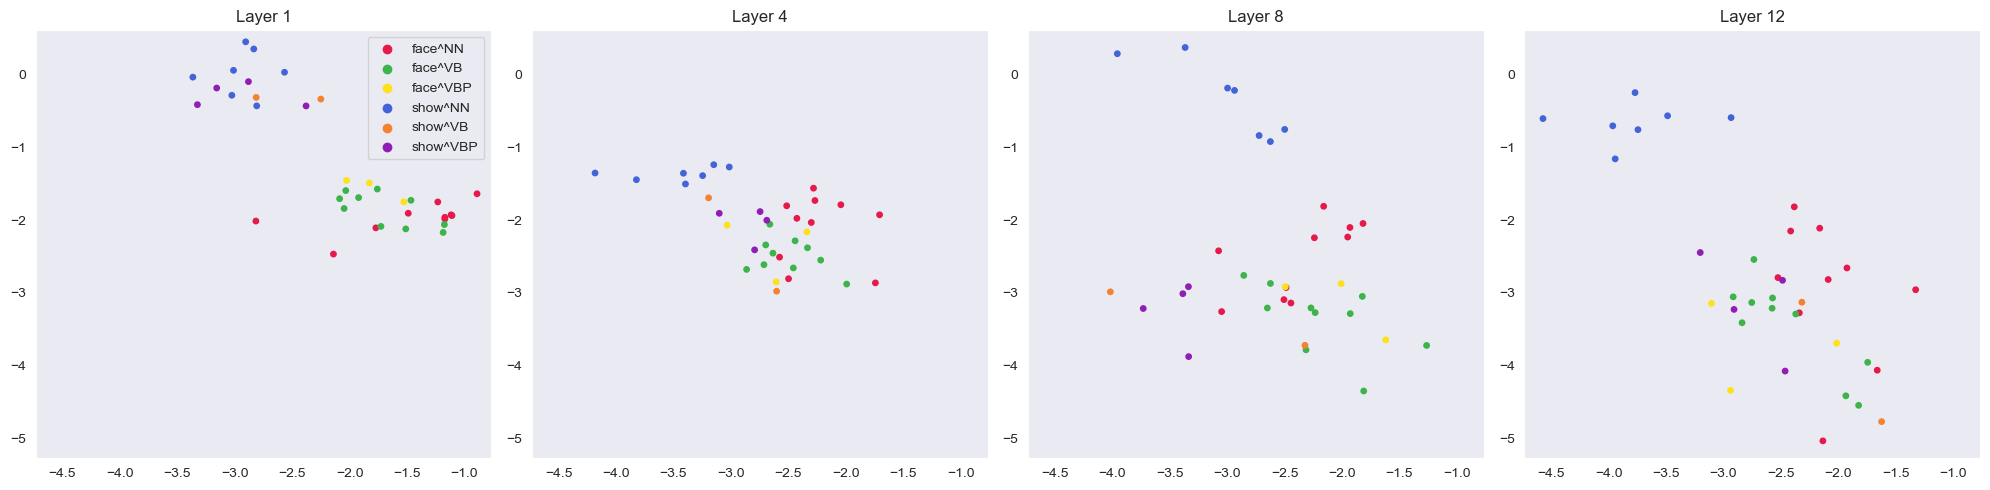

In [3]:
# Choose tags and layers to plot
plot_layers = [1,4,8,12]
# plot_tags = [
#  'about^IN',
#  'about^RB',
#  'about^RP',
#  'as^IN',
#  'as^RB',
# #  'high^JJ',
# #  'high^NN',
# #  'high^NNP',
# #  'high^RB',
# #  'new^JJ',
# #  'new^NNP',
#  'up^IN',
#  'up^RB',
#  'up^RP',
# #  'yield^NN',
# #  'yield^VB',
#  'face^NN',
#  'face^VB',
#  'face^VBP',
#  'show^NN',
#  'show^NNP',
#  'show^VB',
#  'show^VBP'
# ]

# plot_tags = [
# #  'about^IN',
# #  'about^RB',
# #  'about^RP',
# #  'as^IN',
# #  'as^RB',
# #  'high^JJ',
#  'high^NN',
#  'high^NNP',
# #  'high^RB',
#  'new^JJ',
#  'new^NNP',
# #  'up^IN',
# #  'up^RB',
# #  'up^RP',
#  'yield^NN',
#  'yield^VB',
#  'face^NN',
#  'face^VB',
#  'face^VBP',
#  'show^NN',
#  'show^NNP',
#  'show^VB',
#  'show^VBP'
# ]


plot_tags = [
 'face^NN',
 'face^VB',
 'face^VBP',
 'show^NN',
#  'show^NNP',
 'show^VB',
 'show^VBP'
]
 

# Filter the features, tags and layers to only include the words with tags in plot_tags
filt = np.isin(t, plot_tags)
X_filtered = X[:,filt]
t_filtered = np.array(t)[filt]
layer_filtered = np.array(layer)[filt]

# Dictionary of colours for each tag
tag_colours = {tag:colours_lst[i] for i, tag in enumerate(plot_tags)}


### Scale + fit PCA
scaler = StandardScaler()
pca = PCA(n_components=2)

## - FIT TO ONLY THE SELECTED TAGS
# X_filtered_scaled = scaler.fit_transform(X_filtered.T)
# principalComponents = pca.fit_transform(X_filtered_scaled)

## - FIT TO ALL FEATURES THEN FILTER TO SELECTED TAGS
# Scale the features
X_scaled = scaler.fit_transform(X.T)
principalComponents = pca.fit_transform(X_scaled)
principalComponents = principalComponents[filt,:]

# Create a dataframe with the PCA components, tags and layers
df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
df['tag'] = t_filtered
df['layer'] = layer_filtered
df['tag_c'] = df['tag'].map(tag_colours)


### Plot the PCA components for selected layers

fig, axes = plt.subplots(nrows=1, ncols=len(plot_layers), figsize=(20, 5))
for i, layer_number in enumerate(plot_layers):
    ax = fig.axes[i]
    df_layer = df[df['layer']==layer_number]
    ax.scatter(df_layer['pc1'], df_layer['pc2'], c=df_layer['tag_c'],s=15)
    ax.set_title(f'Layer {layer_number}')
    
    # Generate a legend for the first subplot
    if i==0:
        for tag in plot_tags:
            ax.scatter([], [], c=tag_colours[tag], label=tag)
        ax.legend()


# Set the x and y limits for all subplots to be the same
x_min = min(ax.get_xlim()[0] for ax in fig.axes)
x_max = max(ax.get_xlim()[1] for ax in fig.axes)
y_min = min(ax.get_ylim()[0] for ax in fig.axes)
y_max = max(ax.get_ylim()[1] for ax in fig.axes)
for ax in fig.axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
fig.tight_layout()
plt.show()